# Predicting House Prices with Regression

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](resources/regression.png)

## Load the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print(f"Libraries Imported!!")

Libraries Imported!!


## Global Constants and Functions

In [2]:
column_names = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']

In [3]:
def plot_loss(history):
    h = history.history
    x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(range(x_lim), h['val_loss'], label = 'Validation Loss')
    plt.plot(range(x_lim), h['loss'], label = 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [4]:
def plot_predictions(preds, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds, y_test, 'ro')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.plot([-0.5, 0.5], [-0.5, 0.5], 'b--')
    plt.show()
    return

In [5]:
def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

## Importing the Data

In [6]:
df = pd.read_csv('data/houseprices.csv', names=column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157



### Check for missing data

In [7]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

## Data Normalization

It is easier for optimization algorithms to find minimas by normalizing the data before training a model

In [8]:
df = df.drop(labels='serial', axis=1)
df.head()

,date,age,distance,stores,latitude,longitude,price
0,2009,21,9,6,84,121,14264
1,2007,4,2,3,86,121,12032
2,2016,18,3,7,90,120,13560
3,2002,13,2,2,80,128,12029
4,2014,25,5,8,81,122,14157


In [9]:
# Normalizing the data
df_norm = (df - df.mean())/df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


### Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [10]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

## Creating training and test sets

In [11]:
# Select features
features = df_norm.drop(labels='price', axis=1)
features.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


In [12]:
# Select labels
target = df_norm['price']
target.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

In [13]:
print(f"Features shape - {features.shape}")
print(f"Labels shape - {target.shape}")

Features shape - (5000, 6)
Labels shape - (5000,)


In [14]:
# Perform the training and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                            target, test_size=0.1, random_state=0)

print(f"Shapes of training set - {features_train.shape} and {target_train.shape}")
print(f"Shapes of testing set - {features_test.shape} and {target_test.shape}")

Shapes of training set - (4500, 6) and (4500,)
Shapes of testing set - (500, 6) and (500,)


## Create the Model

In [15]:
# We will define a function to create the model
def get_model():
    model = Sequential([
        Dense(10, input_shape=(features_train.shape[1], ), activation=tf.nn.relu),
        Dense(20, activation=tf.nn.relu),
        Dense(5, activation=tf.nn.relu),
        Dense(1)
    ])

    model.compile(loss='mse', optimizer='adam')
    return model

In [16]:
# initialize a model
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


2022-01-19 18:38:49.363482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model Training

We can use EarlyStopping callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs

In [17]:
es_cb = EarlyStopping(monitor='val_loss', patience=5)

# We will run some predictions on the untrained model
preds_on_untrained = model.predict(features_test)

2022-01-19 18:38:49.454127: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [18]:
# We will run the training
history = model.fit(
    features_train, target_train,
    validation_data=(features_test, target_test),
    epochs=100,
    callbacks=[es_cb]
)

Epoch 1/100
141/141 [==============================] - 1s 5ms/step - loss: 0.9421 - val_loss: 0.4590
Epoch 2/100
141/141 [==============================] - 0s 1ms/step - loss: 0.3589 - val_loss: 0.2139
Epoch 3/100
141/141 [==============================] - 0s 1ms/step - loss: 0.2031 - val_loss: 0.1834
Epoch 4/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1805 - val_loss: 0.1753
Epoch 5/100
141/141 [==============================] - 0s 910us/step - loss: 0.1735 - val_loss: 0.1718
Epoch 6/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1725 - val_loss: 0.1663
Epoch 7/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1658 - val_loss: 0.1644
Epoch 8/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1697 - val_loss: 0.1622
Epoch 9/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1661 - val_loss: 0.1603
Epoch 10/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1639 - val_

### Plot Training and Validation Loss

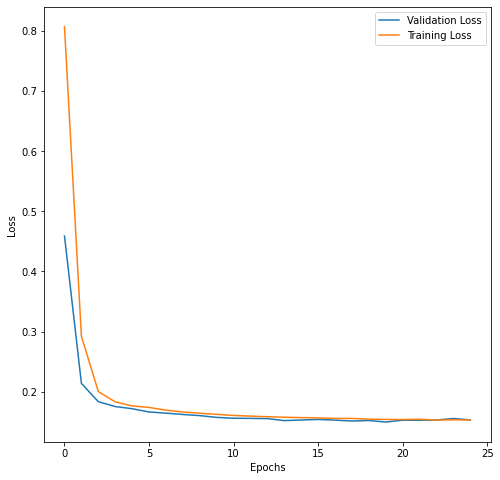

In [19]:
plot_loss(history)

## Predictions

We will use the helper function to compare predictions from the model when it was untrained and when it was trained

/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


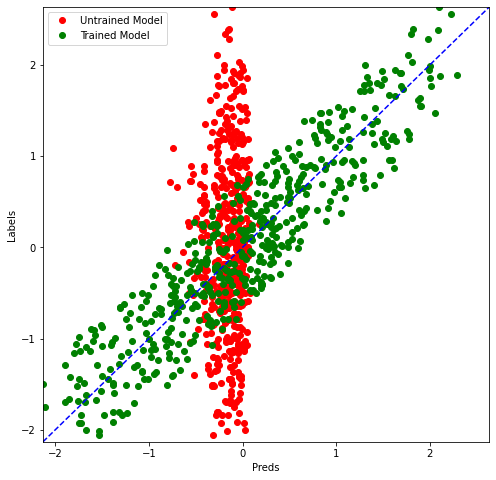

In [20]:
preds_on_trained = model.predict(features_test)
compare_predictions(preds_on_untrained, preds_on_trained, target_test)

### Plot price predictions

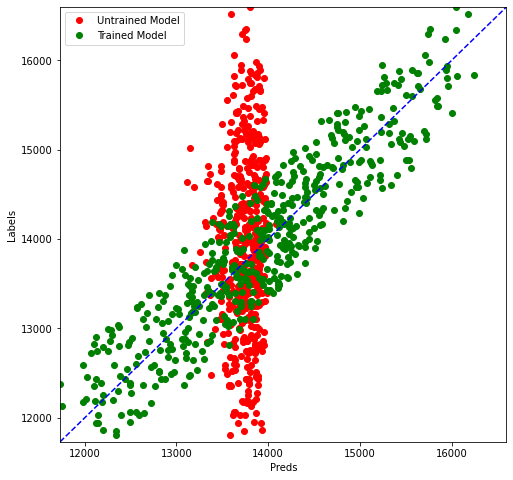

In [21]:
price_untrained = [convert_label_value(item) for item in preds_on_untrained]
price_trained = [convert_label_value(item) for item in preds_on_trained]
price_test = [convert_label_value(item) for item in target_test]

# We will plot using compare predictions
compare_predictions(price_untrained, price_trained, price_test)